In [184]:
#from PiFM_read.py in Data>JessicaKong>Code on server. need to see if it is the same as those in util in hyperAFM
import os
import io
import numpy as np
from skimage import feature, transform, img_as_float
from skimage.measure import compare_ssim as ssim
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from scipy import signal, optimize
from scipy.ndimage import rotate
from igor.binarywave import load
from scipy.signal import detrend

import matplotlib.pyplot as plt

#import 2d cross corr
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

%matplotlib inline
import csv

class PiFMImage():
    """
    A class representing a PiFM image. Give the path to the PiFM data
    and receive a class that stores this information as a hyper image, 
    and series of channel images.
    
    Input: 
        path: Path to ANFATEC parameter file. This is the text file that
        is generated with each scan.
        
    Output: 

    """
    def __init__(self, path):
        
        
        self.channel_names = []
        full_path = os.path.realpath(path)
        directory = os.path.dirname(full_path)
        
        # Get the scan parameters and channel details.
        self.parms, channels =  read_anfatec_params(full_path)
       
        x_pixel = int(self.parms['xPixel'])
        y_pixel = int(self.parms['yPixel'])
        
        #Make one big array for all the data channels.
        channel_data = np.zeros((x_pixel, y_pixel, len(channels)))
        for i, channel in enumerate(channels):
            
            self.channel_names.append(channel['Caption'])
            data = np.fromfile(os.path.join(directory,channel['FileName']),dtype='i4')
            #scaling = float(channel['Scale'])
            channel_data[:,:,i] = np.reshape(data, (256,256))
            
            #for i,line in enumerate(np.split(data,y_pixel)):
            #    for j, pixel in enumerate(np.split(line,x_pixel)):
            #            channel_data[j,i,:] = (scaling*pixel)

        # Here's how we access the different hyper and channel data.
        self.channel_data = channel_data



def read_anfatec_params(path):
    """
    Reads in an ANFATEC parameter file. This file is produced by the Molecular
    Vista PiFM system and describes all parameters need to interpret the data 
    files produced when the data is saved.
    
    Input:
        path: a path to the ANFATEC parameter file.
        
    Output:
        file_descriptions: A list of dictionaries, with each item in the list 
            corresponding to a channel that was recorded by the PiFM.
        scan_params: A dictionary of non-channel specific scan parameters.
        
    """
    file_descriptions = []
    scan_params = {}
    parameters = {}
    inside_description = False

    with io.open(path,  'r', encoding = "ISO-8859-1") as f:
        
        for i,row in enumerate(f): 
            
            # Get rid of newline characters at the end of the line.
            row = row.strip()
            #check to make sure its  not empty 
            if row:
                # First line of the file is useless. We tell the reader to stop at ';'
                if row[0] == unicode(';'):
                    continue
                
                # This string indicates that we have reached a channel description.
                if row.endswith('Begin'):
                    inside_description = True
                    continue

                if row.endswith('End'):
                    file_descriptions.append(parameters)
                    parameters = {}
                    inside_description = False
                   
                #split between :; creates list of two elements 
                split_row = row.split(':')
                
                for i, el in enumerate(split_row):
                    split_row[i] = el.strip()
                
                # We want to save the channel parameters to a separate structure.
                if inside_description:
                    parameters[split_row[0]] = split_row[-1]
                else:
                    scan_params[split_row[0]] = split_row[-1]
                
                
    return scan_params, file_descriptions


def load_ibw(path, flatten=True):
    """
    Given a path to an Igor Binary Wave, return the image file as a 3 dimensional 
    numpy array.
    
    Input:
        path: string file path to .ibw file
        flatten (optional): boolean input to flatten topography data.
    Output:
        data: 3 dimensional numpy array containing .ibw data.
    """
    data = load(path)['wave']['wData']

    # Flatten the topography data by extracting any linear response.
    if flatten == True:   
        flat_topo = data.copy()
        flat_topo[:, :, 0] = detrend(flat_topo[:, :, 0])
        data = flat_topo
        
    data = np.rot90(data)    
    return data

class HyperImage():
    """
    A class representing a Hyper image. Give the path to the Hyper data, and receive a class that 
    stores this information as a hyper image, and series of channel images.
    """
    def __init__(self, path):
        
        self.wavelength_data = None
        self.channel_names = []
        full_path = os.path.realpath(path)
        directory = os.path.dirname(full_path)
        
        # Get the scan parameters and channel details.
        self.parms, channels =  read_anfatec_params(full_path)
        
        x_pixel = int(self.parms['xPixel'])
        y_pixel = int(self.parms['yPixel'])
        
        self.wavelength_data = np.loadtxt(os.path.join(directory,str(channels[0]['FileNameWavelengths'])))
        wavenumber_length = self.wavelength_data.shape[0] 
        image_shape = (x_pixel,y_pixel,wavenumber_length)

        hyper_image = np.zeros(image_shape)
        
        # This scales the integer data into floats.
        pifm_scaling = float(channels[0]['Scale'])
        
        # Read the Raw Hyper data from the bitfile.
        data = np.fromfile(os.path.join(directory,channels[0]['FileName']),dtype='i4')
        for i,line in enumerate(np.split(data,y_pixel)):
            for j, pixel in enumerate(np.split(line,x_pixel)):
                    hyper_image[j,i,:] = pifm_scaling*pixel
                    
        # Put all the different channels into one big array.
        channel_data = np.zeros((x_pixel, y_pixel, len(channels[1:])))
        for ch, channel in enumerate(channels[1:]):
            self.channel_names.append(channel['Caption'])
            data = np.fromfile(os.path.join(directory,channel['FileName']),dtype='i4')
            scaling = float(channel['Scale'])

            for i,line in enumerate(np.split(data,y_pixel)):
                for j, pixel in enumerate(np.split(line,x_pixel)):
                        channel_data[j,i,ch] = (scaling*pixel)

        # Here's how we access the different hyper and channel data.
        self.hyper_image = np.rot90(hyper_image, k=-1)
        self.channel_data = np.rot90(channel_data, k=-1)
        
        self.hyper_image = self.hyper_image[:,::-1,:]
        self.channel_data = self.channel_data[:,::-1,:]
        

In [2]:
f03 = PiFMImage('./../Data/PolymerBlends/Film15_0003.txt')
f04 = PiFMImage('./../Data/PolymerBlends/Film15_0004.txt')
f09 = PiFMImage('./../Data/PolymerBlends/Film15_0009.txt')

f03topo = f03.channel_data[:,:,0]
f04topo = f04.channel_data[:,:,0]
f09topo = f09.channel_data[:,:,0]

f03topoflat1 = signal.detrend(f03topo, axis=1, type="linear")
f04topoflat1 = signal.detrend(f04topo, axis=1, type="linear")
f09topoflat1 = signal.detrend(f09topo, axis=1, type="linear")

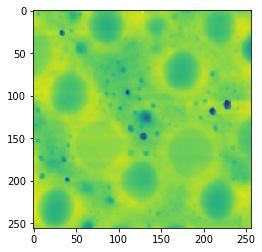

In [3]:
plt.imshow(f03topoflat1)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


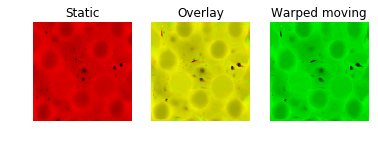

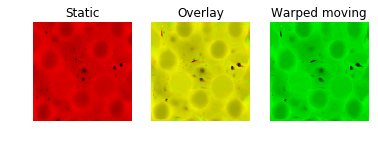

In [4]:
moving = f09topoflat1
static = f03topoflat1

dim = static.ndim
metric = SSDMetric(dim)

level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(static, moving)
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static','Overlay','Warped moving',
   'direct_warp_result.png')


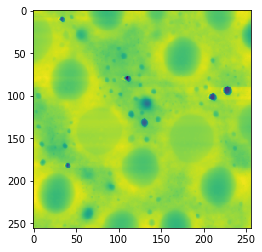

In [5]:
plt.imshow(f09topoflat1)

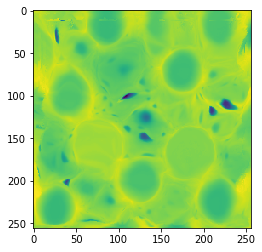

In [6]:
plt.imshow(warped_moving)

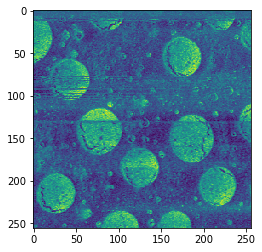

In [7]:
pifm09 = f09.channel_data[:,:,15]
pifm03 = f03.channel_data[:,:,15]
pifm09flat1 = signal.detrend(pifm09, axis=1, type="linear")
pifm03flat1 = signal.detrend(pifm03, axis=1, type="linear")
plt.imshow(pifm09flat1)

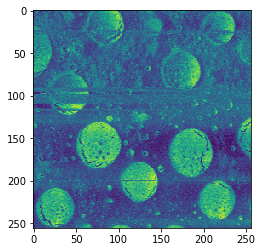

In [8]:
plt.imshow(pifm03flat1)

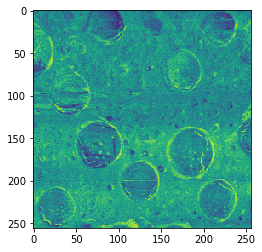

In [10]:
pifm09shifted = mapping.transform(pifm09, 'linear')
diff = pifm09shifted - pifm03flat1
plt.imshow(diff)

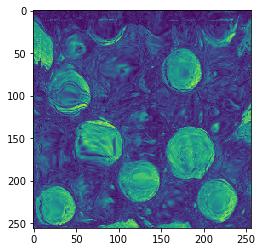

In [13]:
plt.imshow(pifm09shifted)

AttributeError: 'AxesImage' object has no attribute 'min'

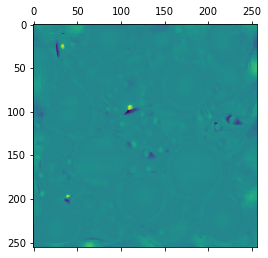

In [14]:
errorimage = plt.matshow(warped_moving-static, cmap='viridis')
regtools.overlay_images(errorimage,'errorimage')

### Try again with SciKitImage

In [16]:
offset_image = f09topoflat1
image = f03topoflat1

### Initial shift: pixel precision

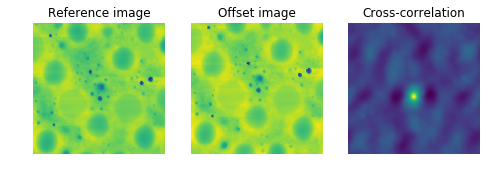

Detected pixel offset (y, x): [ 16.  -1.]


In [17]:
shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()
print("Detected pixel offset (y, x): {}".format(shift))



### Initial Shift: Subpixel precision

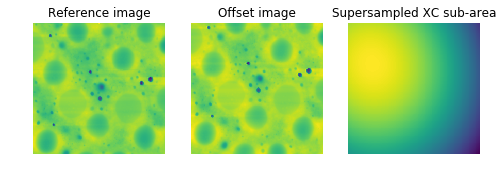

Detected pixel offset (y, x): [ 16.  -1.]


In [18]:
offset_image = f09topoflat1
image = f03topoflat1

shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")

plt.show()
print("Detected pixel offset (y, x): {}".format(shift))


### Shift the offset image: 

In [19]:
offset_imagecrop = offset_image[:-16,1:]
offset_imagepadded = np.zeros((256,256))
offset_imagepadded[:offset_imagecrop.shape[0], :offset_imagecrop.shape[1]] = offset_imagecrop

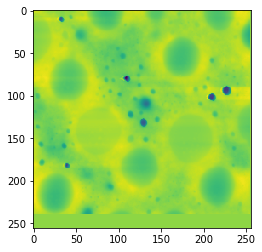

In [20]:
plt.imshow(offset_imagepadded)

### Swap the reference and offset image

In [21]:
image = offset_imagepadded
offset_image = f03topoflat1

### detect pixel shift again

In [22]:
shift, error, diffphase = register_translation(image, offset_image)
print("Detected pixel offset (y, x): {}".format(shift))

Detected pixel offset (y, x): [-16.   0.]


### Shift the original ref image to match offset image 

In [23]:
offset_imagecrop1 = offset_image[16:, :]
offset_imagepadded1 = np.zeros((256,256))
offset_imagepadded1[:offset_imagecrop1.shape[0], :offset_imagecrop1.shape[1]] = offset_imagecrop1

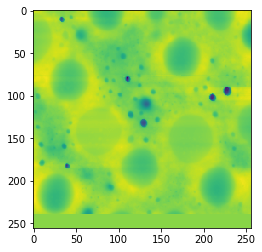

In [24]:
plt.imshow(offset_imagepadded1)

### Check that the two cropped images are aligned

## 2nd shift: pixel precision 

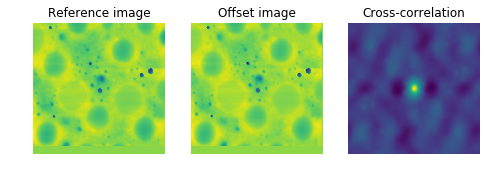

Detected pixel offset (y, x): [ 0.  0.]


In [25]:
offset_image = offset_imagepadded
image = offset_imagepadded1 


shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()
print("Detected pixel offset (y, x): {}".format(shift))

### 2nd shift: Subpixel Precision

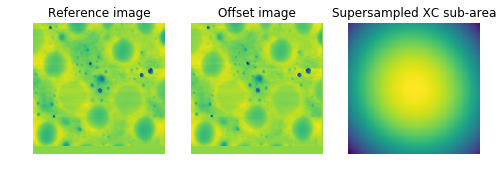

Detected pixel offset (y, x): [ 0.32  0.44]


In [29]:
offset_image = offset_imagepadded
image = offset_imagepadded1 


shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")

plt.show()
print("Detected pixel offset (y, x): {}".format(shift))

### Image Alignment on Perovskite Data

In [38]:
cAFM = load_ibw('./../Data/SKPMcAFM_set2/MAPIFilm12cAFM_0004.ibw')
SKPM = load_ibw('./../Data/SKPMcAFM_set2/MAPIFilm12SKPM_0017.ibw')

cAFMtopo = cAFM[:,:,0]
SKPMtopo = SKPM[:,:,0]

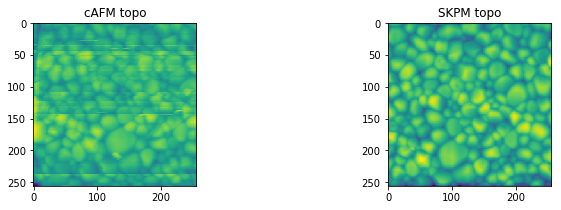

In [56]:
fig = plt.figure(figsize=(18, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(cAFMtopo)
ax1.set_title("cAFM topo")
ax2.imshow(SKPMtopo)
ax2.set_title("SKPM topo")
plt.show()

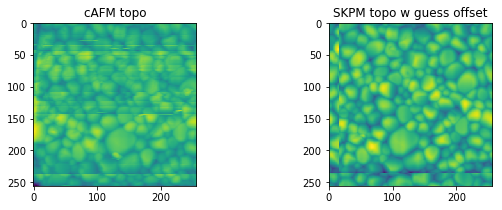

In [62]:
guess = (-20, 15)
SKPM_guess = fourier_shift(np.fft.fftn(SKPMtopo), guess)
SKPM_guess = np.fft.ifftn(SKPM_guess)

fig = plt.figure(figsize=(15, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(cAFMtopo)
ax1.set_title("cAFM topo")
ax2.imshow(SKPM_guess.real)
ax2.set_title("SKPM topo w guess offset")


### Polymer Data 

In [6]:
#load images
hyper1 = HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0005.txt')
hyper2 = HyperImage('./../../Desktop/20170706_0712_0726_P3HTPMMA_hyper/Film10_0026.txt')
cAFM1 = load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/Film10cAFM_0001.ibw')
cAFM2 = load_ibw('./../../Desktop/20170724_0725_0726_PMMAP3HT_cAFM/cAFM3_0000.ibw')

#flatten images
hyper1topo = hyper1.channel_data[55:-3,:,0]
hyper1topoflat = signal.detrend(hyper1topo, axis=1, type="linear")
hyper2topo = hyper2.channel_data[:,:,0]
hyper2topoflat = signal.detrend(hyper2topo, axis=1, type="linear")

cAFM1topo = cAFM1[55:-3,:,0]
cAFM1topoflat = signal.detrend(cAFM1topo, axis=1, type="linear")
cAFM2topo = cAFM2[:,:,0]
cAFM2topoflat = signal.detrend(cAFM2topo, axis=1, type="linear")

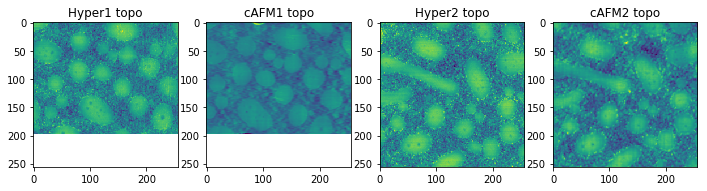

In [7]:
#show images 
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 5, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 5, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax3 = plt.subplot(1, 5, 3, sharex=ax1, sharey=ax1, adjustable='box-forced')
ax4 = plt.subplot(1, 5, 4, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(hyper1topoflat)
ax1.set_title("Hyper1 topo")
ax2.imshow(cAFM1topoflat)
ax2.set_title("cAFM1 topo")
ax3.imshow(hyper2topoflat)
ax3.set_title("Hyper2 topo")
ax4.imshow(cAFM2topoflat)
ax4.set_title("cAFM2 topo")

### Set 2

In [22]:
shift, error, diffphase = register_translation(hyper2topoflat, cAFM2topoflat)
shift, error, diffphase

(array([ 2.,  0.]), 0.88727365829021743, 8.0771201440337631e-16)

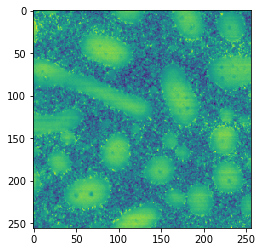

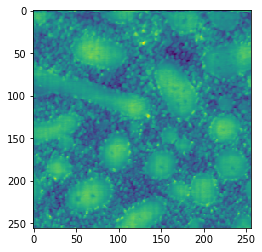

In [40]:
#apply shift
cAFM2shifted0 = fourier_shift(np.fft.fftn(cAFM2topoflat), shift)
cAFM2shifted = np.fft.ifftn(cAFM2shifted0)

#show images after shift 
fig, ax = plt.subplots(1)
ax.imshow(hyper2topoflat)

fig, ax = plt.subplots(1)
ax.imshow(cAFM2shifted.real)

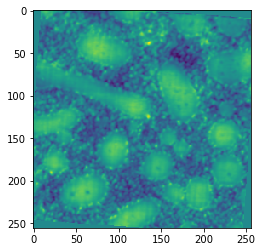

In [41]:
rot = rotate(cAFM2shifted.real, angle=-4, axes=(1,0), reshape=False, prefilter=False)
fig, ax = plt.subplots(1)
ax.imshow(rot)

### Turns out the images *are* shifted the correct amount. There are only two degrees of freedom in Cross-Correlation: translation in the x- and y-axes. The images differ by a rotation, which can be found by iterating between tensorflow.image.rotate or AffineTransform, the structural similarity index, and scipy.optimize. 


In [80]:
#define SSIM explicitly in terms of rotation angle 
def errormetric(guessang):
        """Minimizing this function gives the maximum Structural Similarity Index (SSI)
        with respect to the rotational degree of freedom between two images for a given spatial offset."""
        img = hyper2topoflat
        offimg = cAFM2topoflat
        return 1-ssim(img, rotate(offimg, angle=guessang, axes=(1,0), output=np.float64, reshape=False, prefilter=False))

In [79]:
rotated = rotate(offimg,angle=-4, axes=(1,0), output= np.float64, reshape=False, prefilter=False)
ssim(img, rotated)


8.3624041278226784e-07

In [92]:
guessang = -6
minimize(errormetric, x0=guessang, method='Nelder-Mead', tol=1e-9).x

array([-4.425])

In [90]:
xopt.x[0]

-4.4249999999999963

In [154]:
def findshift(img, offimg):
    """
    Given two images, this function will use SciKit Image's 2D Cross-Correlation
    to find the offset and shift the two images. 
    
    Parameters
    ----------
    
    img: ndarray
        The reference image.
    offimg: ndarray
        The offset image. 
    
    Returns
    -------
    
    offimg_shift: The offset image shifted in x, y space to match that of the reference image. 
    """
    #find shift 
    shift, error, diffphase = register_translation(img, offimg)
    
    return shift, error, diffphase

In [160]:
def applyshift(offimg, shift):

    offimg_shift = fourier_shift(np.fft.fftn(offimg), shift)
    offimg_shift = np.fft.ifftn(offimg_shift).real
    
    return offimg_shift 

In [144]:
def rot(img, deg, axes=(1,0), reshape=False, prefilter=False, output=np.float64): 
    """
    This function will rotate an image a given number of degrees
    
    Parameters
    ----------
    
    img: ndarray
        The reference image.
    deg: float
        Rotation angle in degrees. 
    prefilter:
        
    Returns
    -------
    img_rot: ndarray
        Rotated image of the same dtype and shape as the original image. 
        
    """
    img_rot = rotate(img, angle=deg, axes=axes, reshape=reshape, prefilter=prefilter, output=output)
    
    return img_rot

In [209]:
def optang(img, offimg, guessang, tol=1e-9):
    """
    This function maximizes the Structure Similarity Index (SSI)
    by using Scipy's Nelder-Mead Simplex algorithm.
    
    """
    
    def errormetric(guessang):
        """Minimizing this function gives the maximum Structural Similarity Index (SSI)
        with respect to the rotational degree of freedom between two images for a given spatial offset.
        """
        return 1-ssim(img, rot(offimg, deg=guessang))
    
    deg_opt = minimize(errormetric, x0=guessang, method='Nelder-Mead', tol=tol).x
    
    return deg_opt, errormetric(deg_opt)

In [268]:
img = hyper2topoflat
offimg = cAFM2topoflat
itered = 1
def shiftandrotate(img, offimg, tol=1e-12, guessoff=(0,0), guessang=-2, iter=10):
    """
    Given two images, this function will shift and rotate the offset_image until the 
    Structure Similarity Index (SSI) is maximized sufficiently. SciKit Image's 2D Cross-Correlation
    is used to find the offset. The SSI is minimized by using Scipy's Nelder-Mead Simplex algorithm. 
    
    PARAMETERS:
        img: image to be used as reference
        offimg: image to be aligned with reference
        guessoff: guess pixel offset in format (y, x). Can be helpful if images are severly misaligned
        guessang: guess angle offset, in degrees. Negate to rotate counter clockwise. 
    """

    #apply guess shift
    offimg_shift = applyshift(offimg, guessoff)
    
    #find shift after guessshift is applied 
    offimg_shift = shift(img, offimg)
    
    #apply guess rotation
    offimg_rot = rot(offimg_shift, deg=guessang)
    
    #find rotation by maximizing SSI 
    deg_opt, errormetric = optang(img=img, offimg=offimg, guessang=guessang, tol=tol)

    #apply optimized rotation
    offimg_rot = rot(offimg_rot, deg=deg_opt)
    
    while (1-errormetric)<tol: 
        if guessang < 0: 
            offimg_shift, offimg_rot, deg_opt = shiftandrotate(img, offimg_rot, tol=tol, guessang=guessang-2)
        else: 
            offimg_shift, offimg_rot, deg_opt = shiftandrotate(img, offimg_rot, tol=tol, guessang=guessang+2)
        
    return offimg_shift, offimg_rot, deg_opt

In [269]:
offimg_shift, offimg_rot, deg_opt = shiftandrotate(img, offimg)

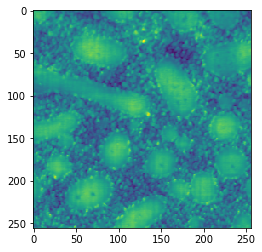

In [260]:
plt.imshow(offimg)

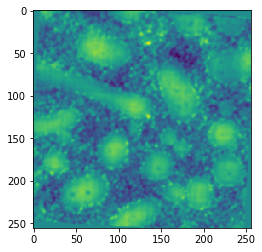

In [270]:
plt.imshow(offimg_rot)

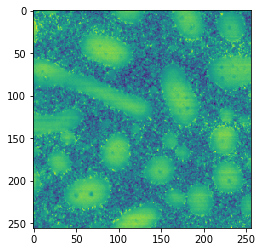

In [255]:
plt.imshow(img)

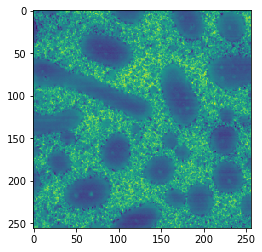

In [271]:
plt.imshow(offimg_rot-img)

In [202]:
deg_opt

array([ 0.])

In [12]:
from scipy.optimize import minimize, rosen

In [17]:
xopt

 final_simplex: (array([[  0.00000000e+00],
       [ -9.53674316e-10]]), array([ 0.99999916,  0.99999916]))
           fun: 0.99999916375989262
       message: 'Optimization terminated successfully.'
          nfev: 55
           nit: 19
        status: 0
       success: True
             x: array([ 0.])

In [42]:
xopt.final_simplex

(array([[  0.00000000e+00],
        [ -9.53674316e-10]]), array([ 0.99999916,  0.99999916]))

In [67]:
rosen

<function scipy.optimize.optimize.rosen>

In [65]:
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)

In [66]:
res

 final_simplex: (array([[ 1.00000002,  1.00000002,  1.00000007,  1.00000015,  1.00000028],
       [ 0.99999999,  0.99999996,  0.99999994,  0.99999986,  0.99999971],
       [ 1.00000005,  1.00000007,  1.00000017,  1.00000031,  1.00000063],
       [ 1.00000004,  1.00000008,  1.00000013,  1.00000025,  1.00000047],
       [ 0.99999999,  0.99999996,  0.99999994,  0.99999984,  0.99999963],
       [ 1.00000005,  1.00000004,  1.00000003,  1.00000003,  1.00000004]]), array([  1.94206402e-13,   2.44964782e-13,   3.10422870e-13,
         3.37952410e-13,   5.52173609e-13,   7.16586838e-13]))
           fun: 1.9420640199868412e-13
       message: 'Optimization terminated successfully.'
          nfev: 494
           nit: 295
        status: 0
       success: True
             x: array([ 1.00000002,  1.00000002,  1.00000007,  1.00000015,  1.00000028])